## Hyperparameter Tuning with Keras Tuner

In [ ]:
import sys

# Increase recursion limit to prevent potential issues
sys.setrecursionlimit(100000)

In [1]:
# Step 2: Import necessary libraries
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import os
import warnings

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Set TensorFlow log level to suppress warnings and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter out INFO, 2 = filter out INFO and WARNING, 3 = ERROR only

In [2]:
# Step 3: Load and preprocess the MNIST dataset
(x_train, y_train), (x_val, y_val) = mnist.load_data()
x_train, x_val = x_train / 255.0, x_val / 255.0

print(f'Training data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')

Training data shape: (60000, 28, 28)
Validation data shape: (10000, 28, 28)


In [3]:
# Define a model-building function 

def build_model(hp):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [4]:
# Create a RandomSearch Tuner 

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Display a summary of the search space 
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [5]:
# Run the hyperparameter search 
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val)) 

# Display a summary of the results 
tuner.results_summary() 

Trial 10 Complete [00h 01m 02s]
val_accuracy: 0.979449987411499

Best val_accuracy So Far: 0.979449987411499
Total elapsed time: 00h 09m 36s
Results summary
Results in my_dir\intro_to_kt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
units: 288
learning_rate: 0.0009017908751535636
Score: 0.979449987411499

Trial 04 summary
Hyperparameters:
units: 352
learning_rate: 0.0010770030890731043
Score: 0.9789499938488007

Trial 01 summary
Hyperparameters:
units: 512
learning_rate: 0.00039107946696815123
Score: 0.9782000184059143

Trial 02 summary
Hyperparameters:
units: 256
learning_rate: 0.00031206235622917154
Score: 0.9768500030040741

Trial 08 summary
Hyperparameters:
units: 64
learning_rate: 0.0012802433325822752
Score: 0.9754500091075897

Trial 05 summary
Hyperparameters:
units: 352
learning_rate: 0.004281715032093813
Score: 0.9736000001430511

Trial 06 summary
Hyperparameters:
units: 64
learning_rate: 0.0012584339358744161
Score: 

### Analyzing and using the best hyperparameters

In [6]:
# Step 1: Retrieve the best hyperparameters 

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] 
print(f""" 

The optimal number of units in the first dense layer is {best_hps.get('units')}. 

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 

""") 

# Step 2: Build and Train the Model with Best Hyperparameters 
model = tuner.hypermodel.build(best_hps) 
model.fit(x_train, y_train, epochs=10, validation_split=0.2) 

# Evaluate the model on the test set 
test_loss, test_acc = model.evaluate(x_val, y_val) 
print(f'Test accuracy: {test_acc}') 

 

The optimal number of units in the first dense layer is 288. 

The optimal learning rate for the optimizer is 0.0009017908751535636. 


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8764 - loss: 0.4296 - val_accuracy: 0.9615 - val_loss: 0.1337
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9672 - loss: 0.1118 - val_accuracy: 0.9702 - val_loss: 0.1032
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9814 - loss: 0.0658 - val_accuracy: 0.9743 - val_loss: 0.0855
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9856 - loss: 0.0473 - val_accuracy: 0.9750 - val_loss: 0.0863
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9905 - loss: 0.0318 - val_accuracy: 0.9761 - val_loss: 0.0880
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9932 - loss: 0.0235 - val_accuracy: 0.9774 - val_loss: 0.0792
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9953 - loss: 

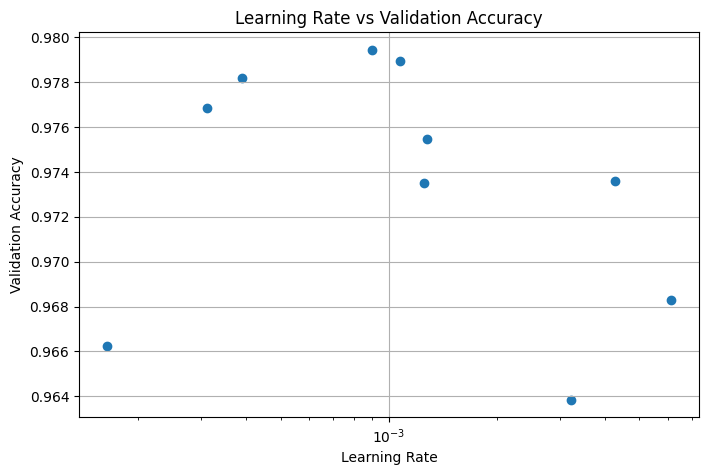

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

trial_data = []
for trial in tuner.oracle.trials.values():
    row = trial.hyperparameters.values
    row['score'] = trial.score
    trial_data.append(row)

df = pd.DataFrame(trial_data)

plt.figure(figsize=(8, 5))
plt.scatter(df['learning_rate'], df['score'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Validation Accuracy')
plt.grid(True)
plt.show()


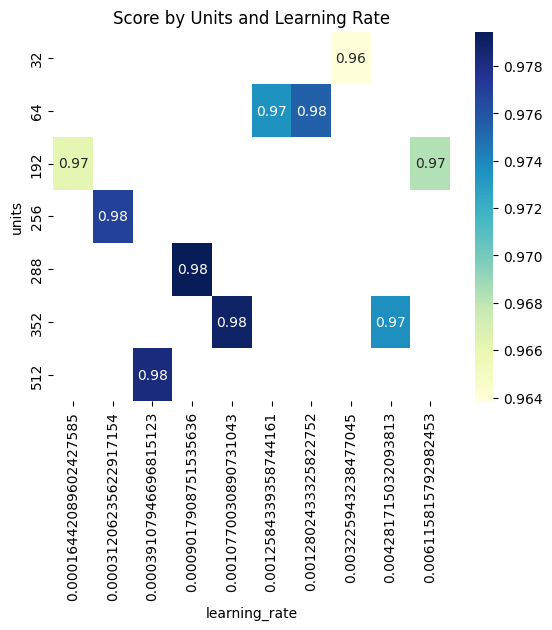

In [ ]:
import seaborn as sns

pivot_table = df.pivot_table(values='score',
                             index='units',
                             columns='learning_rate',
                             aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title("Score by Units and Learning Rate")
plt.show()